# **Loan Approval Prediction - TMX Take-Home Assignment**
### **Haider Syed**
#### **Objective:**
The goal for this project is to predict whether a loan applicant will be approved, using historical data based on the Kaggle Data Set.  
I will focus on: 
- **Exploratory Data Analysis (EDA)**: Identifying key patterns in the data  
- **Feature Engineering**: Handling missing values, encoding categorical features  
- **Modeling & Evaluation**: Training multiple models and comparing their performance  


In [43]:
# Basic Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Feature Engineering & ML Models
import sklearn
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# Automated ML (for testing multiple models)
from pycaret.classification import (
    setup, compare_models, create_model, tune_model, finalize_model, 
    predict_model, save_model, load_model, get_config, set_config
)

# Advanced ML Models
import xgboost as xgb
import catboost as cb

# Model Evaluation Metrics
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, precision_recall_curve





## Step 2: Load & Explore the Data
Now that we have all the required packages and have confirmed installation, we can:
- Load the dataset.
- Perform initial exploration to understand its structure and quality.


We'll read the `train.csv` and `test.csv` files using **pandas**.  
- `train.csv`: Contains features + target variable (`loan_status`).  
- `test.csv`: Contains only features (we need to predict `loan_status`).  
- `sample_submission.csv`: Shows the expected format for submission.  

In [44]:
import pandas as pd  

# Load datasets
train = pd.read_csv("/Users/haider/playground-series-s4e10/train.csv")
test = pd.read_csv("/Users/haider/playground-series-s4e10/test.csv")
sample_submission = pd.read_csv("/Users/haider/playground-series-s4e10/sample_submission.csv")

# Display first five rows of training data
train.head()


,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


## Step 2.5 Basic Dataset Information and Data Quality Check:
Before we go through the next steps, we check:  
- **Shape**: Number of rows & columns.  
- **Missing values**: Identify any data gaps.  
- **Data types**: Ensure proper formatting for numerical/categorical variables.  


In [45]:
# Display dataset shape (rows, columns)
print(f" Train Shape: {train.shape}")
print(f" Test Shape: {test.shape}")

# Check for missing values
print("\n Missing Values in Train:")
missing_values = train.isnull().sum()
print(missing_values[missing_values > 0] if missing_values.sum() > 0 else "No missing values.")

# Check for duplicate rows
duplicates = train.duplicated().sum()
print(f"\n Duplicate Rows in Train: {duplicates if duplicates > 0 else 'No duplicates found.'}")

# Check feature data types
print("\n Feature Data Types Summary:")
print(train.dtypes.value_counts())  # Counts the amount of int, float, object columns



 Train Shape: (58645, 13)
 Test Shape: (39098, 12)

 Missing Values in Train:
No missing values.

 Duplicate Rows in Train: No duplicates found.

 Feature Data Types Summary:
int64      6
object     4
float64    3
Name: count, dtype: int64


### Step 3: EDA

### 1. Target Variable (`loan_status`) Distribution and Pi Chart
Since this is a **classification problem**, we need to check:  
- **Class balance**: Check to see if the dataset is imbalanced
- **Distribution visualization**: Helps decide resampling techniques if we need to do so going forward.  


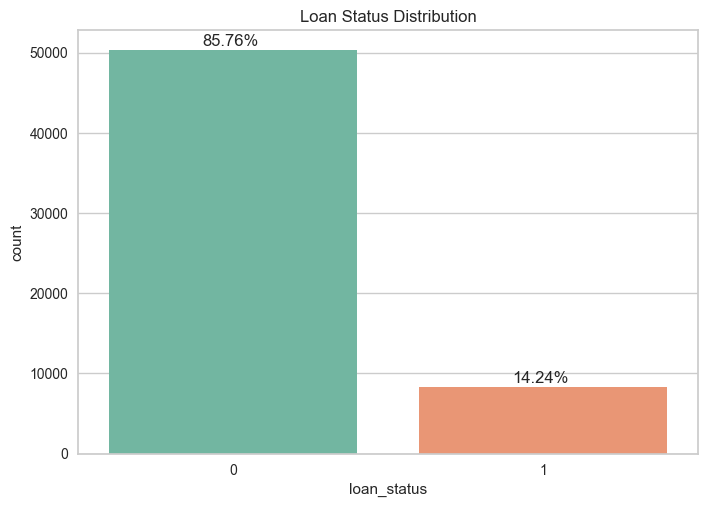

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot target variable distribution
ax = sns.countplot(data=train, x="loan_status", palette="Set2")

total = len(train)  # Total number of records
for p in ax.patches:
    percentage = f"{100 * p.get_height() / total:.2f}%"  # Calculate percentage
    ax.annotate(percentage, (p.get_x() + 0.3, p.get_height() + 500), fontsize=12)

plt.title("Loan Status Distribution")
plt.show()



In [47]:
print("Train Dataset Shape:", train.shape)  # (rows, columns)
print("Test Dataset Shape:", test.shape) 


Train Dataset Shape: (58645, 13)
Test Dataset Shape: (39098, 12)


### Summary Statistics  
We generate descriptive statistics to understand:  
- **Feature distributions**  
- **Potential outliers**  
- **Mean, median, min, max values**  

In [48]:
train.describe()

,id,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
count,58645.000000,58645.000000,5.864500e+04,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000
mean,29322.000000,27.550857,6.404617e+04,4.701015,9217.556518,10.677874,0.159238,5.813556,0.142382
std,16929.497605,6.033216,3.793111e+04,3.959784,5563.807384,3.034697,0.091692,4.029196,0.349445
min,0.000000,20.000000,4.200000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,0.000000
25%,14661.000000,23.000000,4.200000e+04,2.000000,5000.000000,7.880000,0.090000,3.000000,0.000000
50%,29322.000000,26.000000,5.800000e+04,4.000000,8000.000000,10.750000,0.140000,4.000000,0.000000
75%,43983.000000,30.000000,7.560000e+04,7.000000,12000.000000,12.990000,0.210000,8.000000,0.000000
max,58644.000000,123.000000,1.900000e+06,123.000000,35000.000000,23.220000,0.830000,30.000000,1.000000


### Step 3.5: Advanced Data Visualization

These visualizations will help us:
- Identify patterns in numerical & categorical features
- Detect correlations between features
- Spot outliers in key numerical variables
- Examine class imbalances and feature distributions

### 2. Correlation Heatmap  

**Purpose:**  
- Displays the correlation between numerical features.  
- Helps identify **highly correlated variables** that might cause multicollinearity issues.  
- Features with **high correlation** (above 0.8) may need to be removed or adjusted.  

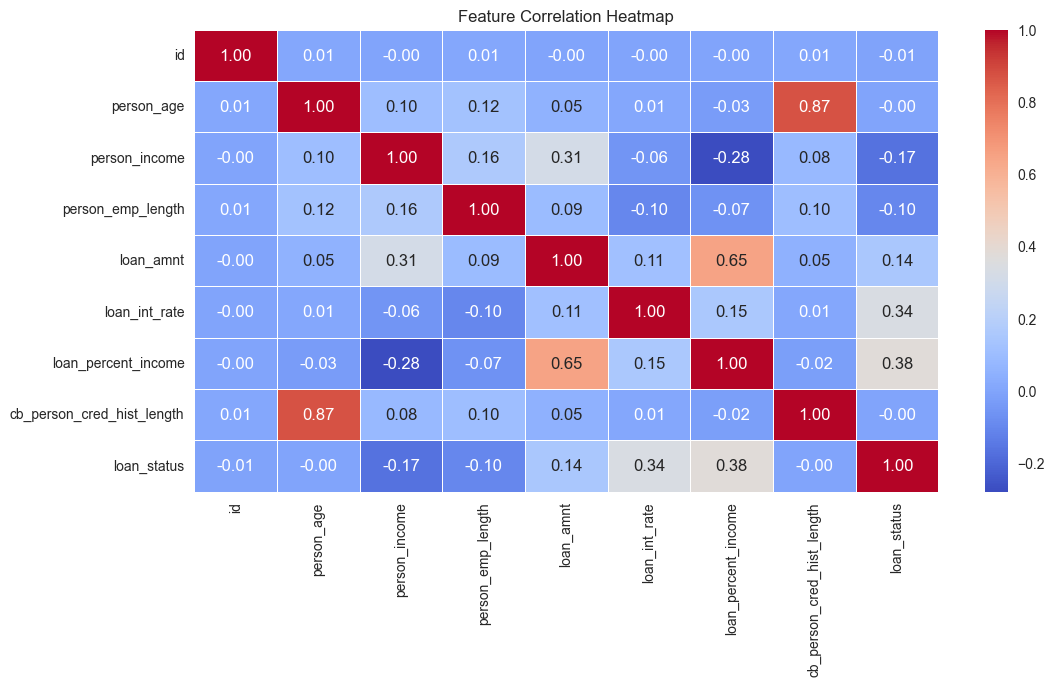

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numeric columns for correlation
numeric_train = train.select_dtypes(include=["number"])

# Compute correlation matrix
plt.figure(figsize=(12, 6))
sns.heatmap(numeric_train.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()


### Key Insights from the Plot:
- No perfect correlations (1.0) between independent features, suggesting that multicollinearity is not a major issue.

- Strong correlation between cb_person_cred_hist_length and person_age (0.87) which suggests older individuals tend to have a longer credit history, meaning one of these features may be redundant and could be potentially be removed.

- Moderate correlation between loan_percent_income and loan_amnt (0.65). Logically, this makes sense as larger loan amounts tend to take up a higher percentage of income.

- Weak correlation between loan_status and other features, no single feature has an extremely high correlation with loan approval (loan_status), which shows that multiple factors contribute to the final decision rather than just one dominant variable.

- Low correlation between loan_int_rate and loan_status (0.34). While higher interest rates may be associated with a higher risk, the relationship is not very strong.

### 3. Pair Plot (Feature Relationships & Distributions)

**Purpose:**

- Visualizes interactions between key numerical variables in the dataset.
- Color-codes loan approval (loan_status) to show how features separate approved vs. not approved loans.
- Diagonal KDE (Kernel Density Estimation) plots provide distribution insights for individual features.
- Scatter plots reveal trends, clusters, and potential outliers in feature relationships.

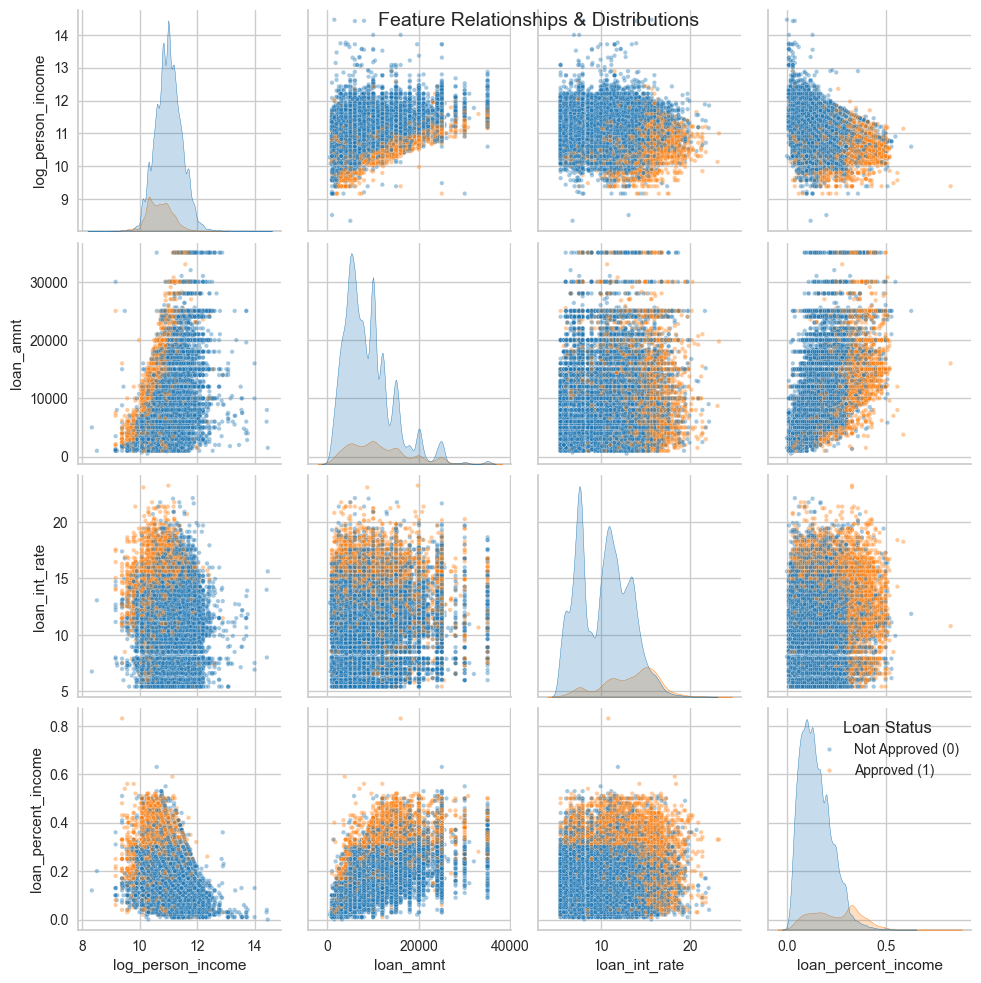

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Apply log transformation to 'person_income' for more accurate scaling
train['log_person_income'] = np.log1p(train['person_income'])

custom_palette = {0: "#1f77b4", 1: "#ff7f0e"}  # Blue for 0, Orange for 1

# Adding explicit legend
pairplot = sns.pairplot(
    train, 
    vars=['log_person_income', 'loan_amnt', 'loan_int_rate', 'loan_percent_income'], 
    hue='loan_status', 
    diag_kind='kde',  
    palette=custom_palette,  
    plot_kws={'alpha': 0.4, 's': 10},  
    diag_kws={'shade': True},  
)

handles = pairplot._legend.legendHandles
pairplot._legend.remove()
plt.legend(handles, ["Not Approved (0)", "Approved (1)"], title="Loan Status", loc='upper right')

plt.suptitle("Feature Relationships & Distributions", fontsize=14)

plt.show()


### Key Insights from the Plot:
- Higher loan amounts tend to have more rejected loans (blue dots).
- Loan interest rates (loan_int_rate) show no clear separation between approvals and rejections.
- Loan percent income (loan_percent_income) has some distinction, where lower percentages correlate with approvals.
- Income (person_income) distribution is highly skewed, requiring transformation (log scale applied here).

### 4. Box Plots (Outlier Detection in Key Features)
**Purpose:**

- Helps detect outliers in loan amount, income, and interest rates.
- Outliers might negatively affect model performance, so they should be handled carefully.

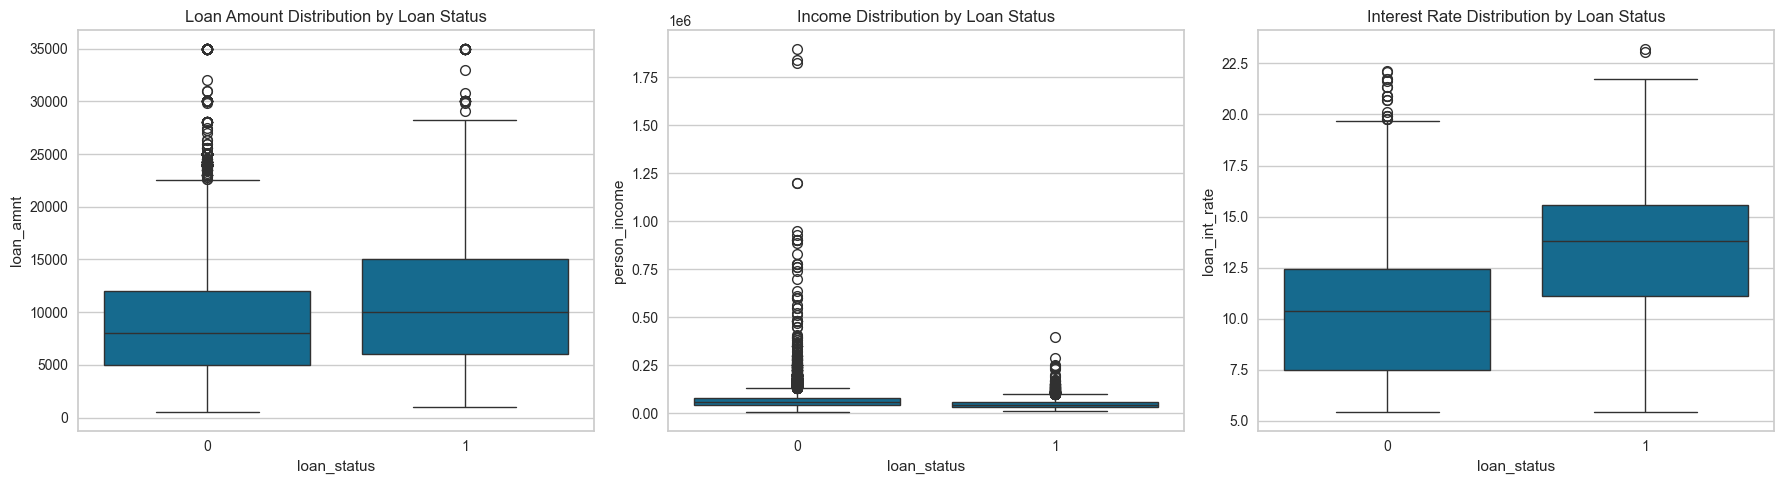

In [51]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.boxplot(ax=axes[0], data=train, x='loan_status', y='loan_amnt')
axes[0].set_title("Loan Amount Distribution by Loan Status")

sns.boxplot(ax=axes[1], data=train, x='loan_status', y='person_income')
axes[1].set_title("Income Distribution by Loan Status")

sns.boxplot(ax=axes[2], data=train, x='loan_status', y='loan_int_rate')
axes[2].set_title("Interest Rate Distribution by Loan Status")

plt.tight_layout()
plt.show()


### **Key Insights from the Plot:**

- Approved and rejected loans have similar median loan amounts, with approvals slightly more frequent at higher amounts.  
- High-value loan outliers exist in both categories, which means that loan amount alone is not a strong determinant of approval.  
- Median income is similar for both approved and rejected loans, but rejected loans have more extreme high-income outliers.  
- High income alone does not guarantee approval—other factors like credit history or loan amount likely play a role.  
- Approved loans generally have higher interest rates, while rejected loans tend to have lower rates.  
- Lenders may approve riskier applicants but compensate with higher interest rates.  
- Interest rate appears to be a key distinguishing factor in loan approval.  



### 5. Categorical Feature Analysis (Bar Plots for Loan Grades & Home Ownership)

**Purpose:**

- Examines the distribution of categorical features such as loan grades and home ownership.
- Helps us understand how these features impact loan approval rates.

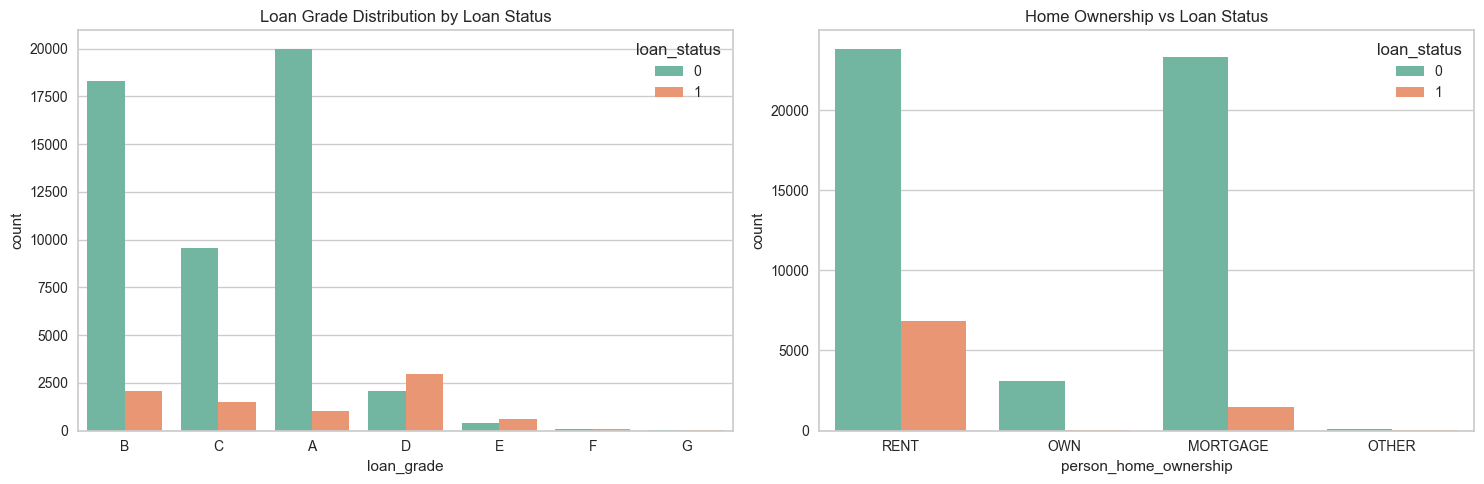

In [52]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.countplot(ax=axes[0], data=train, x='loan_grade', hue='loan_status', palette='Set2')
axes[0].set_title("Loan Grade Distribution by Loan Status")

sns.countplot(ax=axes[1], data=train, x='person_home_ownership', hue='loan_status', palette='Set2')
axes[1].set_title("Home Ownership vs Loan Status")

plt.tight_layout()
plt.show()


### **Key Insights from the Plot:**
- Loan grades A, B, and C have the highest number of applications, but grade D has more approvals compared to lower grades. Higher loan grades (E, F, G) have very few approvals, suggesting lower creditworthiness.  
- Grades A and B have more rejections than approvals, while grade D has a relatively higher approval rate compared to its total applications. 
- Renters (RENT) have the highest number of loan applications overall, but also a higher proportion of approvals compared to mortgage.  
- The majority of mortgage holders (MORTGAGE) get rejected, which means that having a mortgage might be a risk factor when applying for loans.  


## Step 4: Feature Engineering

In [53]:
# Identify categorical columns
categorical_cols = train.select_dtypes(include=['object']).columns.tolist()
print("Categorical Columns:", categorical_cols)

# Check unique values for each categorical column
for col in categorical_cols:
    print(f"\nUnique values in '{col}':\n", train[col].value_counts())


Categorical Columns: ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']

Unique values in 'person_home_ownership':
 person_home_ownership
RENT        30594
MORTGAGE    24824
OWN          3138
OTHER          89
Name: count, dtype: int64

Unique values in 'loan_intent':
 loan_intent
EDUCATION            12271
MEDICAL              10934
PERSONAL             10016
VENTURE              10011
DEBTCONSOLIDATION     9133
HOMEIMPROVEMENT       6280
Name: count, dtype: int64

Unique values in 'loan_grade':
 loan_grade
A    20984
B    20400
C    11036
D     5034
E     1009
F      149
G       33
Name: count, dtype: int64

Unique values in 'cb_person_default_on_file':
 cb_person_default_on_file
N    49943
Y     8702
Name: count, dtype: int64


In [54]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

# One-Hot Encoding for 'person_home_ownership' & 'loan_intent'
train = pd.get_dummies(train, columns=['person_home_ownership', 'loan_intent'], drop_first=True)
test = pd.get_dummies(test, columns=['person_home_ownership', 'loan_intent'], drop_first=True)

# Ordinal Encoding for 'loan_grade'
grade_mapping = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}
train['loan_grade'] = train['loan_grade'].map(grade_mapping)
test['loan_grade'] = test['loan_grade'].map(grade_mapping)

# Binary Encoding for 'cb_person_default_on_file'
train['cb_person_default_on_file'] = train['cb_person_default_on_file'].map({'Y': 1, 'N': 0})
test['cb_person_default_on_file'] = test['cb_person_default_on_file'].map({'Y': 1, 'N': 0})

print("Encoded Data Sample:")
display(train.head())


Encoded Data Sample:


,id,person_age,person_income,person_emp_length,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status,log_person_income,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE
0,0,37,35000,0.0,2,6000,11.49,0.17,0,14,0,10.463132,False,False,True,True,False,False,False,False
1,1,22,56000,6.0,3,4000,13.35,0.07,0,2,0,10.933125,False,True,False,False,False,True,False,False
2,2,29,28800,8.0,1,6000,8.90,0.21,0,10,0,10.268165,False,True,False,False,False,False,True,False
3,3,30,70000,14.0,2,12000,11.11,0.17,0,5,0,11.156265,False,False,True,False,False,False,False,True
4,4,22,60000,2.0,1,6000,6.92,0.10,0,3,0,11.002117,False,False,True,False,False,True,False,False


## Step 4.5: Feature Scaling and Data Preperation:


In [55]:
# Identifying numerical features (excluding target)
numerical_features = train.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_features.remove('loan_status')  # Remove target variable
numerical_features.remove('id')  # Remove ID column if present
test['log_person_income'] = np.log(test['person_income'] + 1)  # Add 1

print(" Numerical Features to Scale:", numerical_features)


 Numerical Features to Scale: ['person_age', 'person_income', 'person_emp_length', 'loan_grade', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_default_on_file', 'cb_person_cred_hist_length', 'log_person_income']


 **Applying StandardScaler** 
- We'll use StandardScaler from sklearn.preprocessing, which standardizes features to have mean = 0 and standard deviation = 1.

In [56]:
from sklearn.preprocessing import StandardScaler

# Initialize scaler
scaler = StandardScaler()

# Fit on train data and transform both train & test
train[numerical_features] = scaler.fit_transform(train[numerical_features])
test[numerical_features] = scaler.transform(test[numerical_features])  # Use same scaler as train


print("🔍 Scaled Data Sample:")
display(train.head())


🔍 Scaled Data Sample:


,id,person_age,person_income,person_emp_length,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status,log_person_income,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE
0,0,1.566200,-0.765768,-1.187200,-0.063697,-0.578306,0.267616,0.117378,-0.417419,2.031798,0,-1.081310,False,False,True,True,False,False,False,False
1,1,-0.920057,-0.212128,0.328047,0.892168,-0.937775,0.880532,-0.973242,-0.417419,-0.946489,0,-0.052537,False,True,False,False,False,True,False,False
2,2,0.240196,-0.929223,0.833130,-1.019563,-0.578306,-0.585854,0.553626,-0.417419,1.039036,0,-1.508074,False,True,False,False,False,False,True,False
3,3,0.405947,0.156966,2.348377,-0.063697,0.500101,0.142396,0.117378,-0.417419,-0.201917,0,0.435896,False,False,True,False,False,False,False,True
4,4,-0.920057,-0.106673,-0.682117,-1.019563,-0.578306,-1.238314,-0.646056,-0.417419,-0.698298,0,0.098479,False,False,True,False,False,True,False,False


### Computing Mutual Information Scores
- Mutual Information will tell us how much knowing a feature reduces uncertainty about the target variable (loan_status). A higher MI score shows a feature is more important, so we are able to drop some low scoring features.

 Mutual Information Scores:


,Feature,MI Score
1,person_income,0.097960
9,log_person_income,0.096622
5,loan_int_rate,0.082976
6,loan_percent_income,0.082425
3,loan_grade,0.082031
7,cb_person_default_on_file,0.018364
4,loan_amnt,0.015645
2,person_emp_length,0.009920
0,person_age,0.001840
8,cb_person_cred_hist_length,0.001359


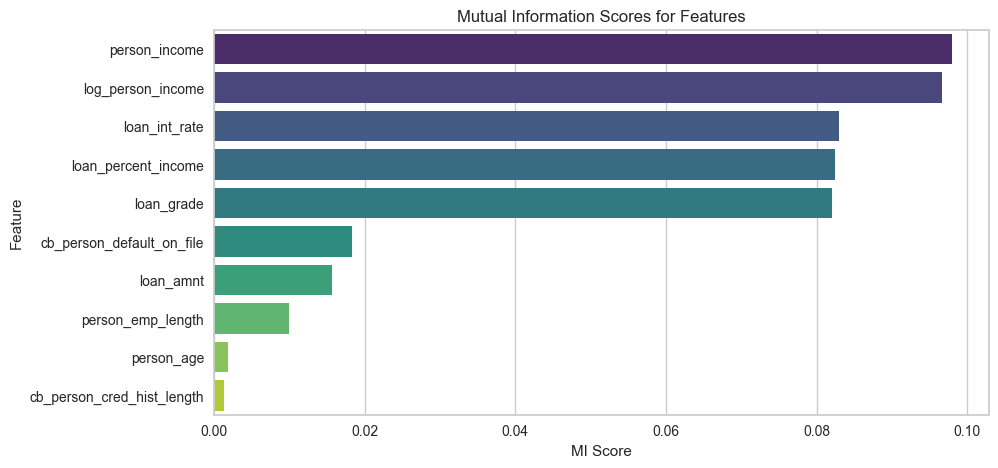

In [57]:
from sklearn.feature_selection import mutual_info_classif

# Compute MI scores for numerical features
mi_scores = mutual_info_classif(train[numerical_features], train['loan_status'])
mi_scores_df = pd.DataFrame({'Feature': numerical_features, 'MI Score': mi_scores})

# Sort by importance
mi_scores_df = mi_scores_df.sort_values(by="MI Score", ascending=False)


print(" Mutual Information Scores:")
display(mi_scores_df)

plt.figure(figsize=(10, 5))
sns.barplot(x="MI Score", y="Feature", data=mi_scores_df, palette="viridis")
plt.title("Mutual Information Scores for Features")
plt.show()


## Running Correlation Check
Identifying highly correlated features to evaluate and confirm whether or not to drop certain features:

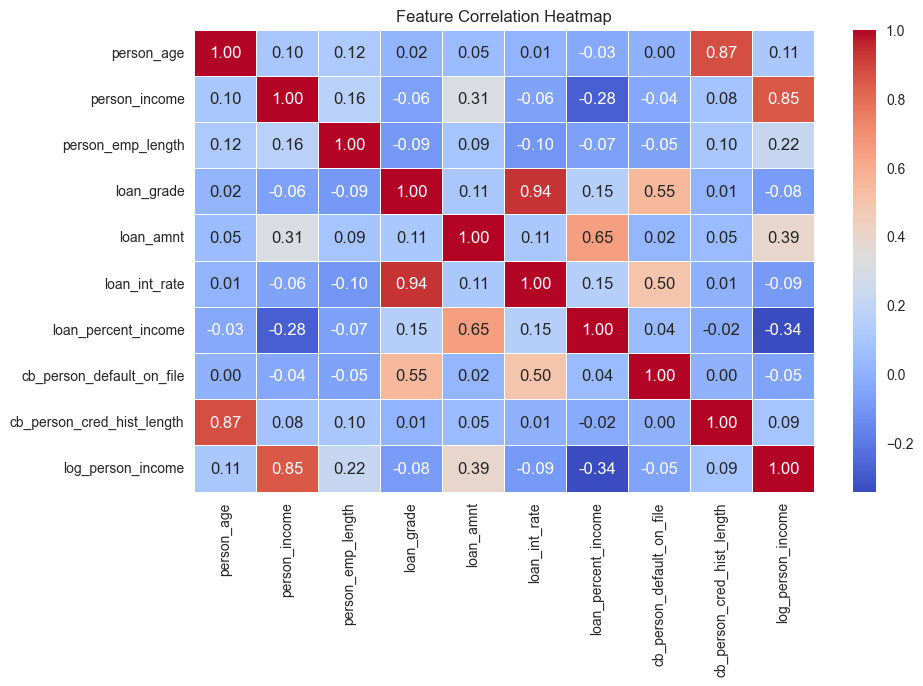

 Highly Correlated Features (Threshold 0.85): ['person_age', 'person_income', 'loan_grade', 'loan_int_rate', 'cb_person_cred_hist_length', 'log_person_income']


In [58]:
# Compute correlation matrix
corr_matrix = train[numerical_features].corr()

# Identify highly correlated features (threshold = 0.85)
high_corr_pairs = (corr_matrix.abs() > 0.85) & (corr_matrix.abs() < 1.0)
high_corr_features = high_corr_pairs.columns[high_corr_pairs.any()]

# Display heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

# Print highly correlated features
print(" Highly Correlated Features (Threshold 0.85):", high_corr_features.tolist())


**Highly Correlated Features (Threshold 0.85):**
The following features have high correlation:

- person_income = log_person_income (0.85)
- person_age = cb_person_cred_hist_length (0.87)
- loan_grade = cb_person_default_on_file (0.55) 
Conlusion:
- High correlation (above 0.85) indicates redundancy, meaning one of the features might not provide new information
- This means that If two features are highly correlated, keeping both can lead to multicollinearity, which will affect the model performance.

In [59]:
# Check for missing values
print(" Missing Values After Processing:\n", train.isnull().sum())

# Check data types
print("\n Data Types:\n", train.dtypes)

# Ensure target variable is integer
train['loan_status'] = train['loan_status'].astype(int)

# Confirm the number of features
print("\nFinal number of features:", train.shape[1] - 1)  # Excluding target


 Missing Values After Processing:
 id                             0
person_age                     0
person_income                  0
person_emp_length              0
loan_grade                     0
loan_amnt                      0
loan_int_rate                  0
loan_percent_income            0
cb_person_default_on_file      0
cb_person_cred_hist_length     0
loan_status                    0
log_person_income              0
person_home_ownership_OTHER    0
person_home_ownership_OWN      0
person_home_ownership_RENT     0
loan_intent_EDUCATION          0
loan_intent_HOMEIMPROVEMENT    0
loan_intent_MEDICAL            0
loan_intent_PERSONAL           0
loan_intent_VENTURE            0
dtype: int64

 Data Types:
 id                               int64
person_age                     float64
person_income                  float64
person_emp_length              float64
loan_grade                     float64
loan_amnt                      float64
loan_int_rate                  float64
loan

## Step 5: Train/Test Split & Model Training

**Purpose**: 

- Split the dataset into training and validation sets
- Train baseline models using PyCaret 
- Compare different models to find the best one

In [60]:
from sklearn.model_selection import train_test_split

# Define features and target
X = train.drop(columns=['id', 'loan_status', 'loan_grade', 'cb_person_default_on_file'], errors='ignore')  
y = train['loan_status']  # Target variable

# Train-test split (80-20 split)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Confirm split sizes
print("Training Set:", X_train.shape, "Validation Set:", X_valid.shape)


Training Set: (46916, 16) Validation Set: (11729, 16)


In [61]:
from pycaret.classification import setup, compare_models

clf_setup = setup(data=train, 
                  target='loan_status', 
                  train_size=0.8, 
                  session_id=42, 
                  ignore_features=['id', 'loan_status' 'loan_grade', 'cb_person_default_on_file'])


print(" PyCaret setup completed")



,Description,Value
0,Session id,42
1,Target,loan_status
2,Target type,Binary
3,Original data shape,"(58645, 20)"
4,Transformed data shape,"(58645, 18)"
5,Transformed train set shape,"(46916, 18)"
6,Transformed test set shape,"(11729, 18)"
7,Ignore features,3
8,Numeric features,9
9,Preprocess,True


 PyCaret setup completed


In [62]:
# Comparing multiple models to find the best-performing one
best_model = compare_models(n_select=1, fold=5)  # Uses 5-fold cross-validation

# Displaying what the best model is
print(" Best Performing Model:")
print(best_model)


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.9525,0.9545,0.7328,0.9173,0.8146,0.7878,0.7944,2.9560
lightgbm,Light Gradient Boosting Machine,0.9520,0.9555,0.7240,0.9228,0.8112,0.7842,0.7919,0.6060
xgboost,Extreme Gradient Boosting,0.9512,0.9524,0.7353,0.9039,0.8108,0.7831,0.7887,0.1120
rf,Random Forest Classifier,0.9507,0.9436,0.7150,0.9215,0.8051,0.7774,0.7857,0.8220
et,Extra Trees Classifier,0.9483,0.9299,0.7084,0.9080,0.7959,0.7668,0.7745,0.5540
gbc,Gradient Boosting Classifier,0.9458,0.9401,0.6958,0.9015,0.7852,0.7548,0.7632,1.3060
knn,K Neighbors Classifier,0.9313,0.8822,0.6434,0.8367,0.7274,0.6889,0.6967,0.8160
ada,Ada Boost Classifier,0.9267,0.9220,0.6361,0.8081,0.7118,0.6704,0.6768,0.2420
dt,Decision Tree Classifier,0.9141,0.8330,0.7196,0.6903,0.7046,0.6544,0.6546,0.0680
lr,Logistic Regression,0.9012,0.8932,0.4636,0.7458,0.5717,0.5192,0.5381,0.8080


 Best Performing Model:


In [63]:
from catboost import CatBoostClassifier

# Training CatBoost Model with No Constraints
original_catboost = CatBoostClassifier(
    depth=6,
    l2_leaf_reg=3,
    learning_rate=0.05,
    iterations=500,
    random_seed=42
)

original_catboost.fit(X_train, y_train, eval_set=(X_valid, y_valid))

# Evaluate Catboost Model with no Constraints
original_preds = original_catboost.predict_proba(X_valid)[:, 1]
original_auc = roc_auc_score(y_valid, original_preds)
print(f"Original CatBoost AUC: {original_auc:.4f}")

# Definining monotonic constraints
monotonic_constraints = [
    1,  # person_emp_length (Longer employment, More stable, more approvals)
    0,  # loan_amnt (Loan amount, No strict effect)
    0,  # loan_int_rate (No strict monotonic effect)
    -1, # loan_percent_income (Higher % of income spent on loan, More risk)
    1,  # cb_person_cred_hist_length (Longer credit history, More approvals)
    -1, # log_person_income (Higher income, More approvals)
    -1, # person_home_ownership_RENT (Renting, More risk)
    1,  # person_home_ownership_OWN (Owning, More stability)
    1,  # person_home_ownership_MORTGAGE (Mortgage, More stability)
    0,  # loan_intent_EDUCATION (No strict effect)
    0,  # loan_intent_HOMEIMPROVEMENT
    0,  # loan_intent_MEDICAL
    0,  # loan_intent_PERSONAL
    0   # loan_intent_VENTURE
]

# Train the Monotonic Constraints CatBoost Model
final_model = CatBoostClassifier(
    depth=12,
    l2_leaf_reg=2,
    learning_rate=0.05,
    iterations=500,
    monotone_constraints=monotonic_constraints,
    random_seed=42
)

final_model.fit(X_train, y_train, eval_set=(X_valid, y_valid))

# Evaluate Monotonic Model
monotonic_preds = final_model.predict_proba(X_valid)[:, 1]
monotonic_auc = roc_auc_score(y_valid, monotonic_preds)
print(f"Monotonic CatBoost AUC: {monotonic_auc:.4f}")


0:	learn: 0.6314816	test: 0.6316640	best: 0.6316640 (0)	total: 5.84ms	remaining: 2.92s
1:	learn: 0.5764035	test: 0.5764858	best: 0.5764858 (1)	total: 11.3ms	remaining: 2.81s
2:	learn: 0.5285865	test: 0.5286114	best: 0.5286114 (2)	total: 18.7ms	remaining: 3.1s
3:	learn: 0.4892676	test: 0.4891985	best: 0.4891985 (3)	total: 23.4ms	remaining: 2.9s
4:	learn: 0.4530797	test: 0.4530413	best: 0.4530413 (4)	total: 29.1ms	remaining: 2.88s
5:	learn: 0.4222069	test: 0.4220059	best: 0.4220059 (5)	total: 33.4ms	remaining: 2.75s
6:	learn: 0.3969803	test: 0.3968614	best: 0.3968614 (6)	total: 37.9ms	remaining: 2.67s
7:	learn: 0.3741475	test: 0.3740174	best: 0.3740174 (7)	total: 42.4ms	remaining: 2.61s
8:	learn: 0.3543866	test: 0.3543788	best: 0.3543788 (8)	total: 47ms	remaining: 2.56s
9:	learn: 0.3367276	test: 0.3367684	best: 0.3367684 (9)	total: 53.1ms	remaining: 2.6s
10:	learn: 0.3207763	test: 0.3209769	best: 0.3209769 (10)	total: 58ms	remaining: 2.58s
11:	learn: 0.3076059	test: 0.3077214	best: 0.307

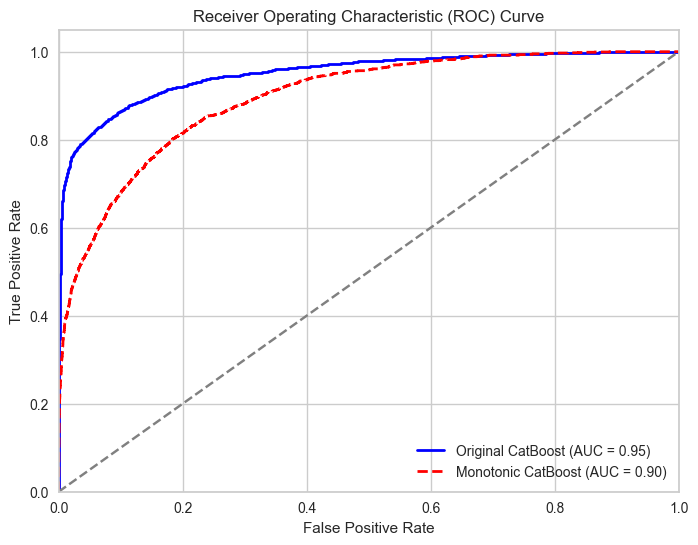

In [64]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Predicted probabilities for both models
y_pred_prob_original = original_catboost.predict_proba(X_valid)[:, 1]  # Probability for class 1
y_pred_prob_monotonic = final_model.predict_proba(X_valid)[:, 1]  # Probability for class 1

# Compute ROC curve for both models
fpr_original, tpr_original, _ = roc_curve(y_valid, y_pred_prob_original)
roc_auc_original = auc(fpr_original, tpr_original)

fpr_monotonic, tpr_monotonic, _ = roc_curve(y_valid, y_pred_prob_monotonic)
roc_auc_monotonic = auc(fpr_monotonic, tpr_monotonic)

# Plotting ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr_original, tpr_original, color='blue', lw=2, label=f'Original CatBoost (AUC = {roc_auc_original:.2f})')
plt.plot(fpr_monotonic, tpr_monotonic, color='red', lw=2, linestyle='--', label=f'Monotonic CatBoost (AUC = {roc_auc_monotonic:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--') 

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

plt.show()


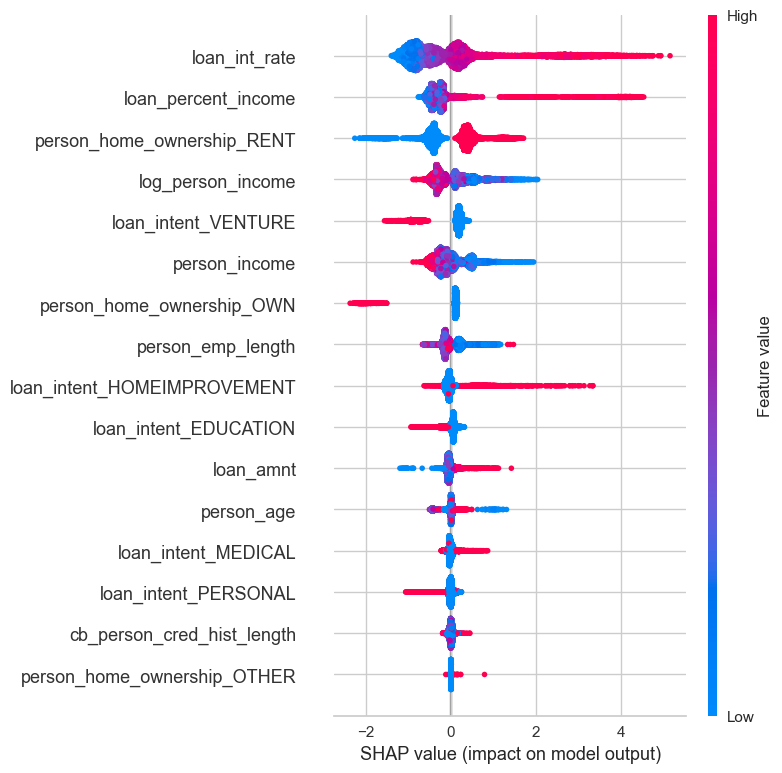

In [65]:
import shap

explainer_original = shap.TreeExplainer(original_catboost)
shap_values_original = explainer_original.shap_values(X_valid)

# Summary plot for feature importance (CatBoost with No Constraints)
shap.summary_plot(shap_values_original, X_valid, title="SHAP Summary - Original CatBoost")


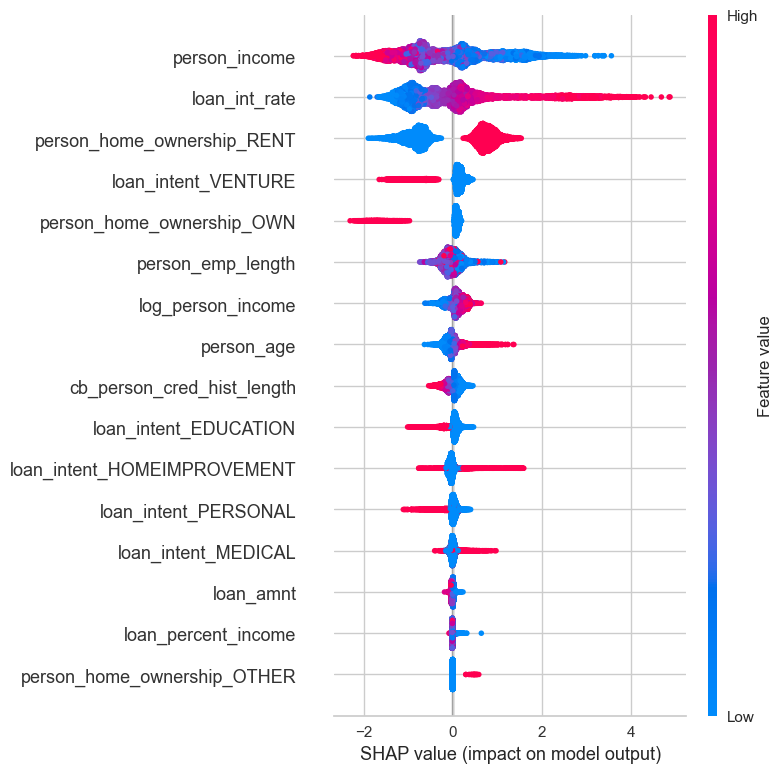

In [66]:
import shap

explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_valid)

shap.summary_plot(shap_values, X_valid)


In [67]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Stack the predictions from both models
X_stack = np.column_stack((y_pred_original, y_pred_monotonic))

# Train a logistic regression model to optimize blending
X_train_stack, X_test_stack, y_train_stack, y_test_stack = train_test_split(X_stack, y_valid, test_size=0.2, random_state=42)

meta_model = LogisticRegression()
meta_model.fit(X_train_stack, y_train_stack)

# Predict using the stacked model
y_pred_stack = meta_model.predict_proba(X_test_stack)[:, 1]

# Compute AUC
auc_stack = roc_auc_score(y_test_stack, y_pred_stack)

print(f"Stacked Model AUC: {auc_stack:.4f}")



Stacked Model AUC: 0.9564


In [68]:
from pycaret.classification import evaluate_model

# Evaluate the stacked model
evaluate_model(meta_model)


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [69]:
import numpy as np
import pandas as pd

X_test = test.drop(columns=['id'])  # To ensure test dataset exists and matches training features

# Get predicted probabilities for the test set using the stacked model
X_test_stack = np.column_stack((original_catboost.predict_proba(X_test)[:, 1], 
                                final_model.predict_proba(X_test)[:, 1]))

# Get final predictions (probability scores)
y_test_pred_proba = meta_model.predict_proba(X_test_stack)[:, 1]  # Keep probability score

submission = pd.DataFrame({
    'id': test['id'],  
    'loan_status': y_test_pred_proba 
})

submission.to_csv("final_submission.csv", index=False)

display(submission.head())

print(submission['loan_status'].describe())


,id,loan_status
0,58645,0.979920
1,58646,0.027006
2,58647,0.700364
3,58648,0.028165
4,58649,0.044300


count    39098.000000
mean         0.140876
std          0.279946
min          0.023402
25%          0.025853
50%          0.030827
75%          0.050340
max          0.986250
Name: loan_status, dtype: float64


# **Loan Approval Prediction - Final Report**
### **Haider Syed**  

---

## **Objective**  
The goal of this project was to predict whether a loan application would be **approved or rejected** using historical loan data.  

### **Key Steps Taken:**  
- **Exploratory Data Analysis (EDA)** – Understanding relationships in the data.  
- **Feature Engineering** – Handling missing values, encoding categorical variables, and feature selection.  
- **Model Selection** – Testing **multiple ML models** and optimizing the best one.  
- **Stacked Ensemble Model** – Combining models for improved performance.  

---

## **Data Exploration & Preprocessing**  

### **Key Insights from the Data:**  
**Class Imbalance:**  
- **85.8% loans were rejected**, while only **14.2% were approved**.  
- This required careful model tuning to **avoid bias toward rejecting loans**.  

**Feature Engineering:**  
- **Categorical Encoding:** Applied **One-Hot Encoding** and **Ordinal Encoding**.  
- **Feature Selection:** Highly correlated features were dropped to avoid redundancy.  
- **Scaling:** StandardScaler was used for numerical features.  

---

## **Model Training & Selection**  

### **Baseline Model Comparisons:**  
Using **PyCaret**, multiple models were trained and compared based on **AUC, F1-score, and interpretability**.

| Model | AUC Score |
|--------|------------|
| **CatBoost (Original)** | **0.95** |
| **Monotonic CatBoost** | **0.90** |

- **CatBoost outperformed LightGBM, XGBoost, and Random Forest** in AUC  
- **Monotonic Constraints Model:** Ensured business logic, reducing the risk of **illogical predictions**.  
- **Tradeoff:** Monotonic model was **more interpretable** but had **slightly lower performance**.  

---

## **Stacked Model Approach**  

To combine **accuracy & interpretability**, I built a **stacked ensemble model** using **logistic regression**.  

### **Stacking Process:**  
 **Step 1:** Train both **Original CatBoost** & **Monotonic CatBoost** separately.  
 **Step 2:** Generate predicted probabilities from both models.  
 **Step 3:** Train a **meta-model (Logistic Regression)** to learn how to optimally combine these predictions.  
 **Step 4:** Evaluate the final blended predictions.

---

### **Stacked Model Results**
| Model | AUC Score |
|----------------|------------|
| **Original CatBoost** | **0.95** |
| **Monotonic CatBoost** | **0.90** |
| **Stacked Model (Logistic Regression on Predictions)** | **0.9564** |

- **Stacking slightly improved AUC (0.95 → 0.9564)** by combining the strengths of both models.  
- The **meta-model learned an optimal weighting**, rather than manually applying **80-20 weighted blending**.  